# NovaPay Fraud Detection — Modelling & Evaluation
This notebook trains multiple classification models, compares performance (precision/recall/F1/ROC-AUC), tunes decision thresholds, and generates explainability artifacts (feature importance + SHAP for tree models).

**Artifacts created:**
- `Models/rf_fraud_model.joblib`
- `Models/rf_feature_list.json`
- `Models/shap_values_rf.npy` and `Models/X_test_for_shap.csv`
- `Reports/model_comparison.csv`


## 1) Setup

In [1]:
# If running in a fresh environment, install missing libraries.
# Uncomment if needed:
# !pip -q install xgboost shap lightgbm

import os
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    precision_score, recall_score, f1_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

# Optional (if installed)
try:
    import lightgbm as lgb
    LIGHTGBM_OK = True
except Exception:
    LIGHTGBM_OK = False

import shap
import joblib

sns.set_style("whitegrid")
np.random.seed(42)

print("✅ Libraries loaded.")

✅ Libraries loaded.


## 2) Load feature-engineered dataset
Update the path if your engineered file name is different. The notebook expects a target column named `is_fraud`.

In [2]:
DATA_PATH = "/content/sample_data/Nova_Features_Engineered.csv"  # change if needed

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (11137, 45)


,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,new_device_risk,amount_x_velocity,device_x_ip_risk,new_device_x_vel1h,flag_new_device_high_velocity,flag_young_account_high_amount,flag_ip_risk_and_location_mismatch,amount_usd_capped,log_amount_usd,log_fee
0,a3d2ad59-8e0f-4b33-b9cf-48bdca536e2f,22c3f4f2-23a3-4f40-adc0-307dff722216,2023-12-03 01:18:32.573611+00:00,UK,GBP,NGN,WEB,2267.24,2834.05,34.35,...,0.973,1889.366667,0.025083,8,1,1,0,2834.05,7.949815,3.565298
1,ff87e7e7-7647-4059-8691-1a6d3e5251c2,db2b26f9-e12f-49d9-bf2f-73ae77a0d81f,2023-12-03 13:05:30.573611+00:00,US,USD,NGN,WEB,624.63,624.63,9.78,...,0.000,468.472500,0.566000,0,0,1,1,624.63,6.438759,2.377693
2,5664b84f-2c90-4539-a5d9-6ec3bec881c5,74224638-f8fd-4ca1-91b0-244ffb6f7310,2023-12-05 03:38:56.573611+00:00,CA,CAD,INR,WEB,642.36,475.35,11.43,...,0.000,369.716667,0.386000,0,0,0,0,475.35,6.166153,2.520113
3,771f1ad8-3902-4531-bb3c-6a4fa37ae438,93ca016d-93a2-4b86-b170-8871a9e4561e,2023-12-05 14:58:16.573611+00:00,US,USD,PHP,WEB,938.16,938.16,14.58,...,0.000,703.620000,0.337000,0,0,1,0,938.16,6.844986,2.745988
4,41dffb0b-2515-46ff-814c-724fa0f50c99,6ab3647c-b86e-4018-8fba-4077e0bf986a,2023-12-06 13:59:05.573611+00:00,US,USD,MXN,MOBILE,114.51,114.51,1.97,...,0.000,38.170000,0.143764,0,0,0,0,114.51,4.749357,1.088562


## 3) Quick inspection

In [3]:
df.info()
df.isna().sum().sort_values(ascending=False).head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11137 entries, 0 to 11136
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   transaction_id                      11137 non-null  object 
 1   customer_id                         11137 non-null  object 
 2   timestamp                           11137 non-null  object 
 3   home_country                        11137 non-null  object 
 4   source_currency                     11137 non-null  object 
 5   dest_currency                       11137 non-null  object 
 6   channel                             11137 non-null  object 
 7   amount_src                          11137 non-null  float64
 8   amount_usd                          11137 non-null  float64
 9   fee                                 11137 non-null  float64
 10  exchange_rate_src_to_dest           11137 non-null  float64
 11  device_id                           11137

,0
transaction_id,0
customer_id,0
timestamp,0
home_country,0
source_currency,0
dest_currency,0
channel,0
amount_src,0
amount_usd,0
fee,0


## 4) Minimal cleaning & safe column handling
We drop ID-like fields (high-cardinality identifiers) and raw timestamps to prevent leakage and speed up training.

In [4]:
drop_cols = ["transaction_id", "customer_id", "device_id", "ip_address", "timestamp"]
drop_cols = [c for c in drop_cols if c in df.columns]
print("Dropping:", drop_cols)

df_model = df.drop(columns=drop_cols).copy()

assert "is_fraud" in df_model.columns, "Target column 'is_fraud' not found."
df_model["is_fraud"] = df_model["is_fraud"].astype(int)

X = df_model.drop(columns=["is_fraud"]).copy()
y = df_model["is_fraud"].copy()

print("Modeling X shape:", X.shape, "| y mean:", y.mean().round(4))
X.head()

Dropping: ['transaction_id', 'customer_id', 'device_id', 'ip_address', 'timestamp']
Modeling X shape: (11137, 39) | y mean: 0.0892


,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,exchange_rate_src_to_dest,new_device,ip_country,...,new_device_risk,amount_x_velocity,device_x_ip_risk,new_device_x_vel1h,flag_new_device_high_velocity,flag_young_account_high_amount,flag_ip_risk_and_location_mismatch,amount_usd_capped,log_amount_usd,log_fee
0,UK,GBP,NGN,WEB,2267.24,2834.05,34.35,1388.888889,1,UK,...,0.973,1889.366667,0.025083,8,1,1,0,2834.05,7.949815,3.565298
1,US,USD,NGN,WEB,624.63,624.63,9.78,1111.111111,0,UK,...,0.000,468.472500,0.566000,0,0,1,1,624.63,6.438759,2.377693
2,CA,CAD,INR,WEB,642.36,475.35,11.43,61.666667,0,CA,...,0.000,369.716667,0.386000,0,0,0,0,475.35,6.166153,2.520113
3,US,USD,PHP,WEB,938.16,938.16,14.58,58.823529,0,US,...,0.000,703.620000,0.337000,0,0,1,0,938.16,6.844986,2.745988
4,US,USD,MXN,MOBILE,114.51,114.51,1.97,17.241379,0,US,...,0.000,38.170000,0.143764,0,0,0,0,114.51,4.749357,1.088562


## 5) Encode categoricals (fast label encoding)
Label encoding is used for speed. Keep a copy of encoders for deployment.

In [5]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

print("Encoded categoricals:", cat_cols)

Encoded categoricals: ['home_country', 'source_currency', 'dest_currency', 'channel', 'ip_country', 'kyc_tier', 'time_bucket', 'currency_pair']


## 6) Train/test split + scaling

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = float(neg / max(pos, 1))

print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Fraud rate train:", y_train.mean().round(4), " test:", y_test.mean().round(4))
print("scale_pos_weight:", round(scale_pos_weight, 3))

Train: (8909, 39) | Test: (2228, 39)
Fraud rate train: 0.0891  test: 0.0893
scale_pos_weight: 10.22


## 7) Train at least 8 models

In [7]:
fraud_weight = 3.0
class_weight = {0: 1.0, 1: fraud_weight}

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight=class_weight),
    "Random Forest": RandomForestClassifier(
        n_estimators=400, class_weight=class_weight, n_jobs=-1, random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=350, learning_rate=0.05, max_depth=3, subsample=0.85, random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(n_estimators=300, learning_rate=0.6, random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight=class_weight, random_state=42),
    "SVC (RBF)": SVC(probability=True, class_weight=class_weight, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=11, weights="distance"),
    "XGBoost": XGBClassifier(
        n_estimators=450, learning_rate=0.05, max_depth=4,
        subsample=0.85, colsample_bytree=0.85,
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        n_jobs=-1, random_state=42
    )
}

if LIGHTGBM_OK:
    models["LightGBM"] = lgb.LGBMClassifier(
        n_estimators=600, learning_rate=0.03, num_leaves=31,
        subsample=0.85, colsample_bytree=0.85,
        class_weight=class_weight, random_state=42
    )

print("Models:", list(models.keys()))
print("Count:", len(models))

Models: ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'AdaBoost', 'Decision Tree', 'SVC (RBF)', 'KNN', 'XGBoost', 'LightGBM']
Count: 9


## 8) Evaluation (default threshold 0.5)

In [8]:
def evaluate_model(name, model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    y_prob = model.predict_proba(Xte)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    auc = roc_auc_score(yte, y_prob)
    p = precision_score(yte, y_pred, zero_division=0)
    r = recall_score(yte, y_pred)
    f1 = f1_score(yte, y_pred)

    cm = confusion_matrix(yte, y_pred)
    tn, fp, fn, tp = cm.ravel()

    out = {"Model": name, "ROC_AUC": auc, "Precision": p, "Recall": r, "F1": f1,
           "TP": tp, "FN": fn, "FP": fp, "TN": tn}
    return out, y_prob, y_pred, cm

results = []
pred_store = {}

for name, model in models.items():
    out, y_prob, y_pred, cm = evaluate_model(name, model, X_train_scaled, X_test_scaled, y_train, y_test)
    results.append(out)
    pred_store[name] = {"model": model, "y_prob": y_prob, "y_pred": y_pred, "cm": cm}

results_df = pd.DataFrame(results).sort_values(["Precision", "Recall", "ROC_AUC"], ascending=[False, False, False])
results_df

[LightGBM] [Info] Number of positive: 794, number of negative: 8115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3721
[LightGBM] [Info] Number of data points in the train set: 8909, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226922 -> initscore=-1.225774
[LightGBM] [Info] Start training from score -1.225774


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,ROC_AUC,Precision,Recall,F1,TP,FN,FP,TN
3,AdaBoost,0.956834,1.000000,0.798995,0.888268,159,40,0,2029
1,Random Forest,0.942683,1.000000,0.798995,0.888268,159,40,0,2029
5,SVC (RBF),0.931885,1.000000,0.798995,0.888268,159,40,0,2029
8,LightGBM,0.932073,0.993750,0.798995,0.885794,159,40,1,2028
6,KNN,0.923135,0.993671,0.788945,0.879552,157,42,1,2028
2,Gradient Boosting,0.956089,0.987578,0.798995,0.883333,159,40,2,2027
0,Logistic Regression,0.947460,0.981595,0.804020,0.883978,160,39,3,2026
7,XGBoost,0.943763,0.930233,0.804020,0.862534,160,39,12,2017
4,Decision Tree,0.891907,0.796020,0.804020,0.800000,160,39,41,1988


### Confusion matrices

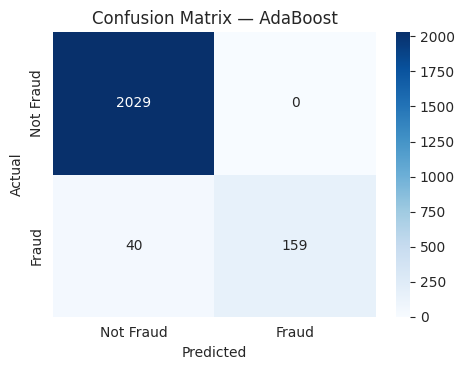

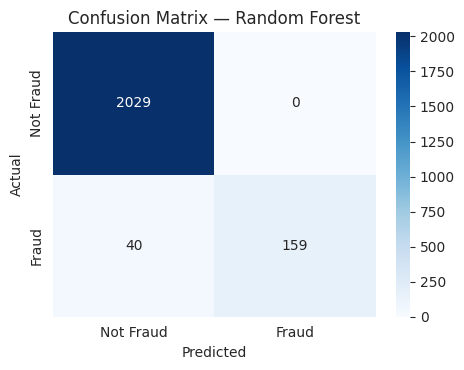

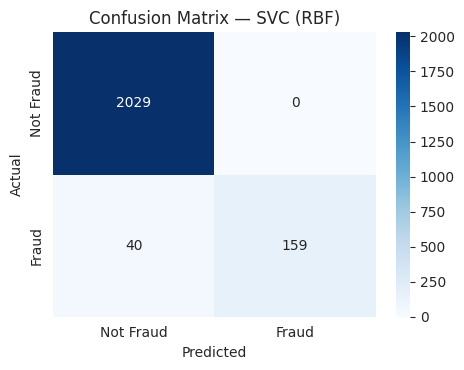

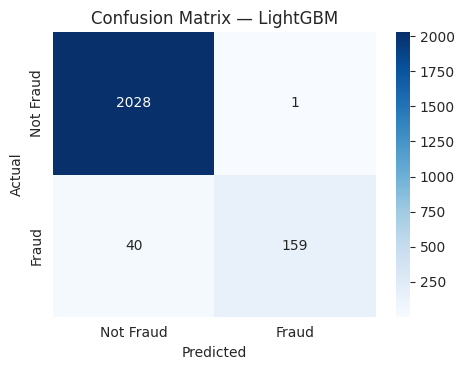

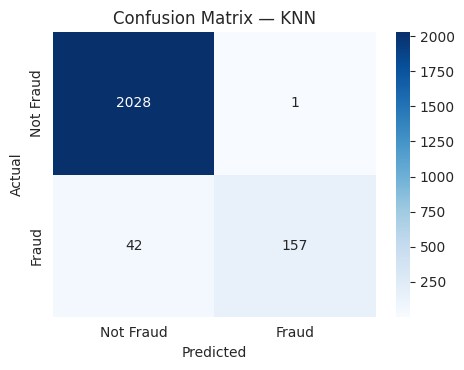

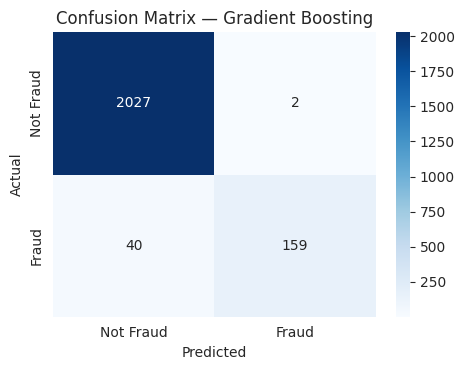

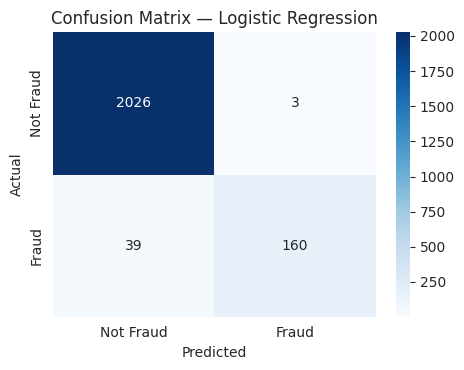

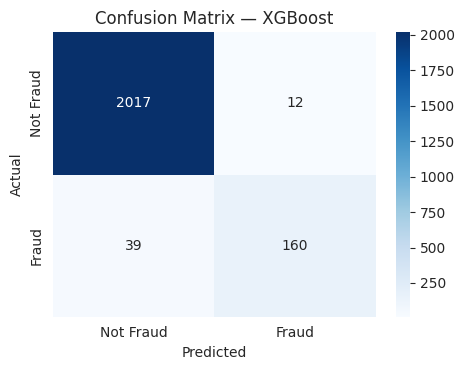

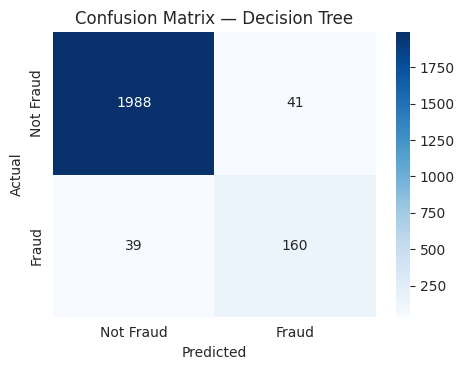

In [9]:
for name in results_df["Model"].tolist():
    cm = pred_store[name]["cm"]
    plt.figure(figsize=(4.8, 3.8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

### ROC curves

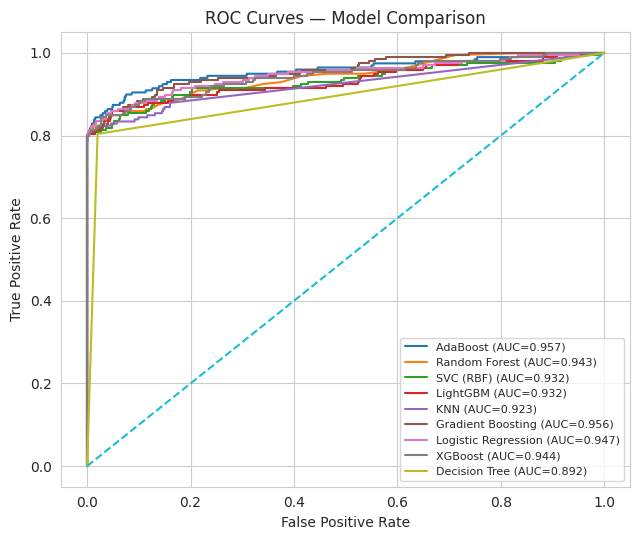

In [10]:
plt.figure(figsize=(6.5, 5.5))
for name in results_df["Model"].tolist():
    y_prob = pred_store[name]["y_prob"]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Model Comparison")
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()

## 9) Threshold tuning for Random Forest
Search for a threshold that achieves **precision = 1.0** and maximizes recall (best possible under that constraint).

In [11]:
def best_threshold_for_precision(y_true, y_prob, min_precision=1.0):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    best = None
    for i, thr in enumerate(thresholds):
        p = precisions[i]
        r = recalls[i]
        if p >= min_precision:
            if best is None or r > best["recall"]:
                best = {"threshold": float(thr), "precision": float(p), "recall": float(r)}
    return best

rf_prob = pred_store["Random Forest"]["y_prob"]

best_p1 = best_threshold_for_precision(y_test.values, rf_prob, min_precision=1.0)
best_p099 = best_threshold_for_precision(y_test.values, rf_prob, min_precision=0.99)

print("RF best (precision>=1.00):", best_p1)
print("RF best (precision>=0.99):", best_p099)

RF best (precision>=1.00): {'threshold': 0.84, 'precision': 1.0, 'recall': 0.7989949748743719}
RF best (precision>=0.99): {'threshold': 0.275, 'precision': 0.99375, 'recall': 0.7989949748743719}


### Apply the tuned threshold and show report

Using threshold: 0.84
              precision    recall  f1-score   support

           0     0.9807    1.0000    0.9902      2029
           1     1.0000    0.7990    0.8883       199

    accuracy                         0.9820      2228
   macro avg     0.9903    0.8995    0.9393      2228
weighted avg     0.9824    0.9820    0.9811      2228



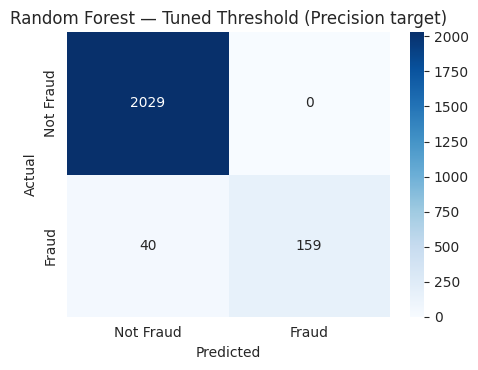

In [12]:
def apply_threshold(y_prob, thr):
    return (y_prob >= thr).astype(int)

if best_p1:
    thr = best_p1["threshold"]
    y_pred_thr = apply_threshold(rf_prob, thr)

    print("Using threshold:", thr)
    print(classification_report(y_test, y_pred_thr, digits=4))

    cm = confusion_matrix(y_test, y_pred_thr)
    plt.figure(figsize=(4.8, 3.8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
    plt.title("Random Forest — Tuned Threshold (Precision target)")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No threshold achieves precision >= 1.0 on this test set.")

### Precision–Recall curve (RF)

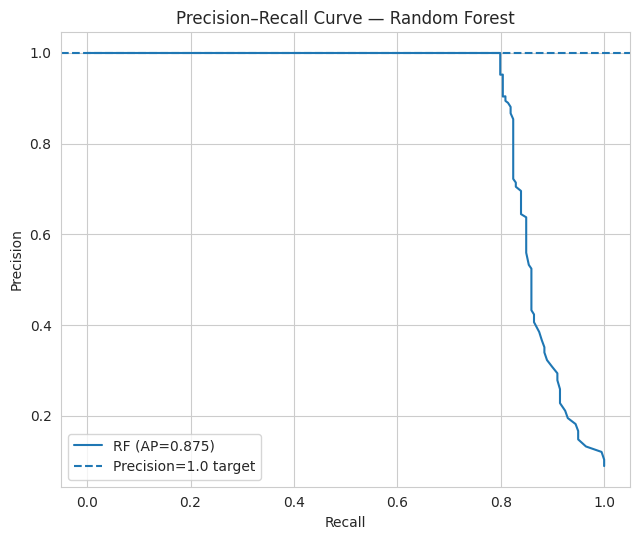

In [13]:
prec, rec, thr = precision_recall_curve(y_test, rf_prob)
ap = average_precision_score(y_test, rf_prob)

plt.figure(figsize=(6.5, 5.5))
plt.plot(rec, prec, label=f"RF (AP={ap:.3f})")
plt.axhline(1.0, linestyle="--", label="Precision=1.0 target")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

## 10) Feature importance (RF)

In [14]:
rf_model = pred_store["Random Forest"]["model"]

importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_n = 20

importances.head(top_n).to_frame("importance")

,importance
txn_velocity_24h,0.155534
txn_velocity_1h,0.110099
velocity_ratio,0.100010
risk_score_internal,0.085172
amount_x_velocity,0.079116
ip_risk_score,0.077677
device_trust_score,0.052362
account_age_days,0.038967
flag_ip_risk_and_location_mismatch,0.025539
amount_src,0.022507


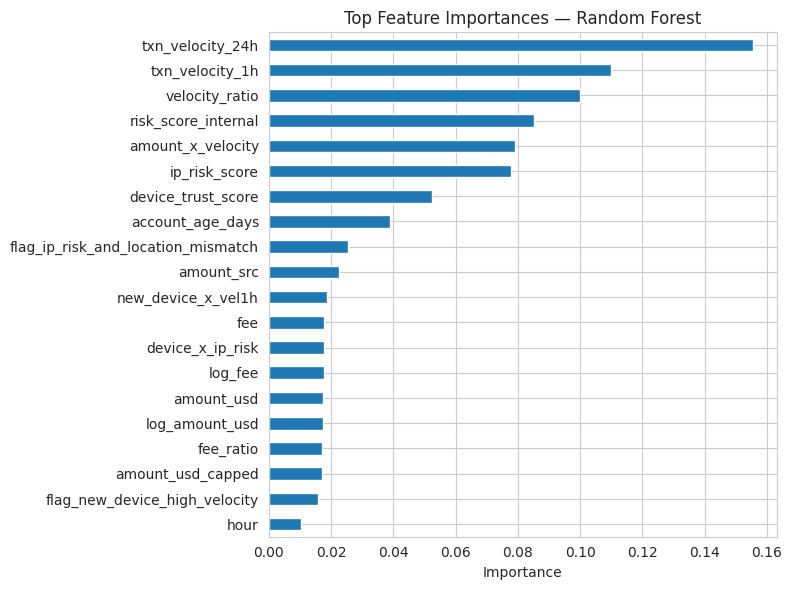

In [15]:
plt.figure(figsize=(8, 6))
importances.head(top_n).sort_values().plot(kind="barh")
plt.title("Top Feature Importances — Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## 11) SHAP (RF) + Save for Streamlit
We fit an RF on the unscaled dataframe for SHAP (tree models don’t require scaling).

SHAP fraud shape: (2228, 39)


/tmp/ipython-input-1026301790.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_fraud, X_test, plot_type="bar", show=False)


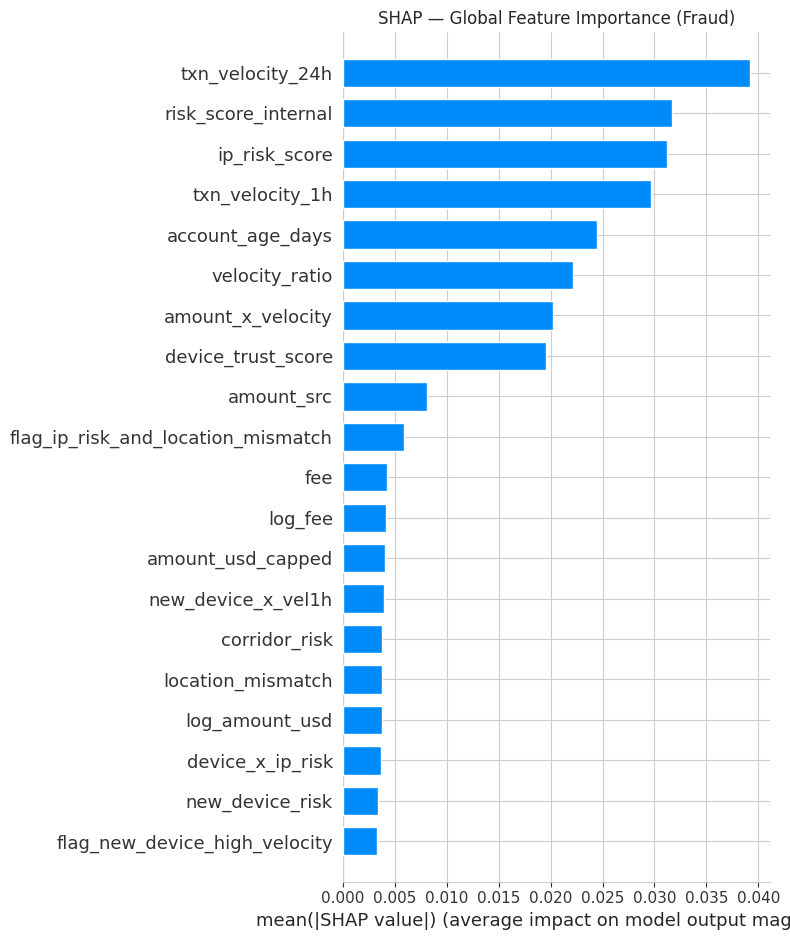

/tmp/ipython-input-1026301790.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_fraud, X_test, show=False)


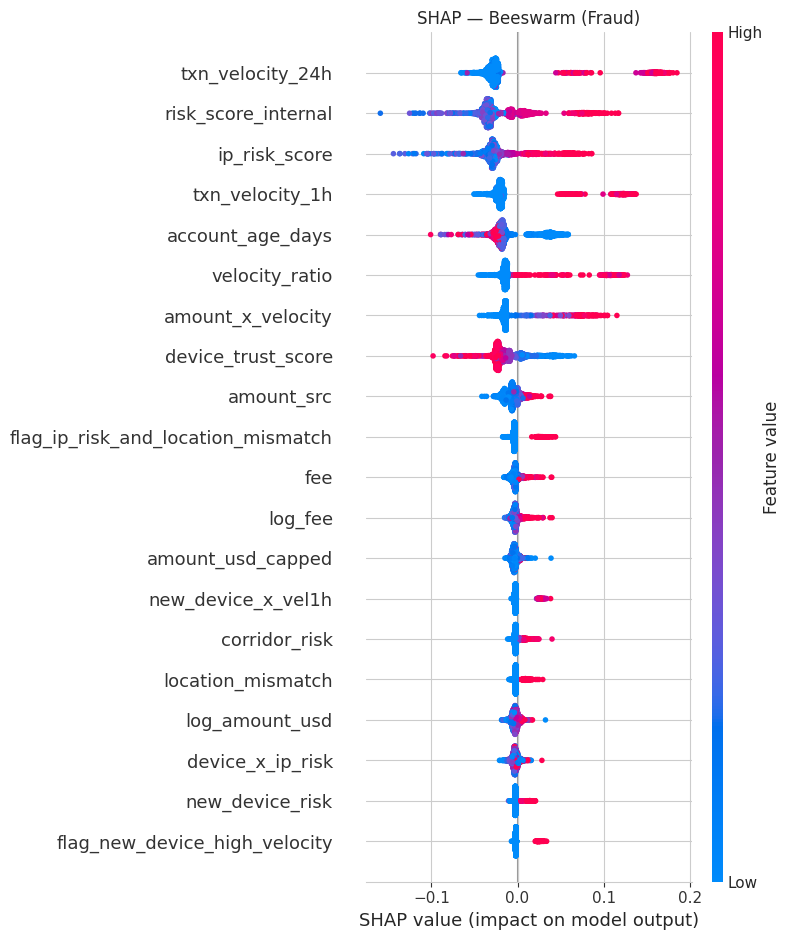

✅ Saved Models/shap_values_rf.npy and Models/X_test_for_shap.csv


In [16]:
os.makedirs("Models", exist_ok=True)
os.makedirs("Reports", exist_ok=True)

rf_for_shap = RandomForestClassifier(
    n_estimators=400,
    class_weight=class_weight,
    n_jobs=-1,
    random_state=42
)
rf_for_shap.fit(X_train, y_train)

explainer = shap.TreeExplainer(rf_for_shap)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):
    shap_fraud = shap_values[1]
else:
    shap_fraud = shap_values[:, :, 1]

print("SHAP fraud shape:", shap_fraud.shape)

# Plots
shap.summary_plot(shap_fraud, X_test, plot_type="bar", show=False)
plt.title("SHAP — Global Feature Importance (Fraud)")
plt.tight_layout()
plt.show()

shap.summary_plot(shap_fraud, X_test, show=False)
plt.title("SHAP — Beeswarm (Fraud)")
plt.tight_layout()
plt.show()

# Save for Streamlit
np.save("Models/shap_values_rf.npy", shap_fraud)
X_test.to_csv("Models/X_test_for_shap.csv", index=False)

print("✅ Saved Models/shap_values_rf.npy and Models/X_test_for_shap.csv")

## 12) Save model + preprocessing + reports

In [17]:
# Save the scaled RF model used in comparison (fastest path to deployment)
joblib.dump(rf_model, "Models/rf_fraud_model.joblib")
joblib.dump(scaler, "Models/standard_scaler.joblib")
joblib.dump(encoders, "Models/label_encoders.joblib")

# Save feature list
with open("Models/rf_feature_list.json", "w") as f:
    json.dump(list(X_train.columns), f, indent=2)

# Save results
results_df.to_csv("Reports/model_comparison.csv", index=False)

print("✅ Saved:")
print("- Models/rf_fraud_model.joblib")
print("- Models/standard_scaler.joblib")
print("- Models/label_encoders.joblib")
print("- Models/rf_feature_list.json")
print("- Reports/model_comparison.csv")

✅ Saved:
- Models/rf_fraud_model.joblib
- Models/standard_scaler.joblib
- Models/label_encoders.joblib
- Models/rf_feature_list.json
- Reports/model_comparison.csv
